In [ ]:
import json
import pandas as pd
import time
from tqdm import tqdm
from openai import OpenAI, RateLimitError, APIError, Timeout, AuthenticationError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
from google.colab import userdata

# Set your API key
OPEN_AI_KEY = userdata.get('OPEN_AI_KEY')
client = OpenAI(api_key=OPEN_AI_KEY)

# Load data
with open('/content/train(1).jsonl') as f:
    train_data = [json.loads(line) for line in f]
with open('/content/test(1).jsonl') as f:
    test_data = [json.loads(line) for line in f][40:83]  # Use 43 Questions from Question no.40 to no.82  for speed

# Prompt builders
def build_prompt(q, style, knn_examples=None):
    if style == "zero-shot":
        return f"Question: {q['question']}\n" + "\n".join([f"{k}. {v}" for k, v in sorted(q['options'].items())])

    if style == "few-shot":
        examples = train_data[:3]

    if style == "knn-few-shot":
        examples = knn_examples or []

    if style in ["few-shot", "knn-few-shot"]:
        prompt = ""
        for ex in examples:
            prompt += f"Question: {ex['question']}\n" + \
                      "\n".join([f"{k}. {v}" for k, v in sorted(ex['options'].items())]) + \
                      f"\nAnswer: {ex['answer_idx']}\n\n"
        prompt += f"Question: {q['question']}\n" + \
                  "\n".join([f"{k}. {v}" for k, v in sorted(q['options'].items())]) + "\nAnswer:"
        return prompt

    if style in ["cot", "self-consistency"]:
        return f"Question: {q['question']}\n" + \
               "\n".join([f"{k}. {v}" for k, v in sorted(q['options'].items())]) + \
               "\nThink step-by-step and explain your reasoning before selecting the best answer."
    return "" # Added a default return for clarity

# API call with retries
def call_openai(prompt, model, temperature=0.0):
    for _ in range(3):
        try:
            res = client.chat.completions.create(
                model=model,
                temperature=temperature,
                messages=[{"role": "user", "content": prompt}]
            )
            return res.choices[0].message.content
        except (RateLimitError, Timeout, APIError, AuthenticationError) as e:
            print("Retrying after error:", e)
            time.sleep(3)
    return ""

#def get_knn_examples(query, k=3):
    vectorizer = TfidfVectorizer().fit([q['question'] for q in train_data])
    train_vecs = vectorizer.transform([q['question'] for q in train_data])
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, train_vecs).flatten()
    top_idxs = sims.argsort()[-k:][::-1]
    return [train_data[i] for i in top_idxs]

# Parse predicted letter
def extract_letter(text):
    for c in ['A', 'B', 'C', 'D', 'E']:
        if c in text:
            return c
    return ""

# Models and techniques
models = {
    "GPT-4.1": "gpt-4-turbo",
    "GPT-4o": "gpt-4o",
    "GPT-3.5": "gpt-3.5-turbo"
}
techniques = ["zero-shot", "few-shot", "knn-few-shot", "cot", "self-consistency"]
results = []

# Run evaluation
for model_name, model_id in models.items():
    for style in techniques:
        print(f"\nEvaluating {model_name} with {style}...")
        for idx, q in enumerate(tqdm(test_data)):
            if style == "knn-few-shot":
                examples = get_knn_examples(q['question'], k=3)
                prompt = build_prompt(q, style, knn_examples=examples)
            else:
                prompt = build_prompt(q, style)

            if style == "self-consistency":
                responses = []
                for _ in range(5):
                    reply = call_openai(prompt, model_id, temperature=0.7)
                    responses.append(extract_letter(reply))
                    time.sleep(1)
                pred = max(set(responses), key=responses.count)
            else:
                reply = call_openai(prompt, model_id)
                pred = extract_letter(reply)

            results.append({
                "model": model_name,
                "technique": style,
                "q_idx": idx,
                "predicted": pred,
                "actual": q['answer_idx'],
                "correct": int(pred == q['answer_idx'])
            })

        # Save results after each model-technique
        pd.DataFrame(results).to_csv("medqa_eval_results.csv", index=False)

# Summary
df = pd.DataFrame(results)
summary = df.groupby(["model", "technique"])["correct"].mean().unstack() * 100
print("\nAccuracy Summary (in %):\n", summary.round(2))








Evaluating GPT-4.1 with zero-shot...


100%|██████████| 43/43 [05:22<00:00,  7.50s/it]



Evaluating GPT-4.1 with few-shot...


100%|██████████| 43/43 [02:50<00:00,  3.97s/it]



Evaluating GPT-4.1 with knn-few-shot...


100%|██████████| 43/43 [14:24<00:00, 20.09s/it]



Evaluating GPT-4.1 with cot...


100%|██████████| 43/43 [07:29<00:00, 10.46s/it]



Evaluating GPT-4.1 with self-consistency...


100%|██████████| 43/43 [41:55<00:00, 58.50s/it]



Evaluating GPT-4o with zero-shot...


100%|██████████| 43/43 [02:09<00:00,  3.00s/it]



Evaluating GPT-4o with few-shot...


100%|██████████| 43/43 [01:08<00:00,  1.59s/it]



Evaluating GPT-4o with knn-few-shot...


100%|██████████| 43/43 [02:47<00:00,  3.90s/it]



Evaluating GPT-4o with cot...


100%|██████████| 43/43 [05:00<00:00,  6.99s/it]



Evaluating GPT-4o with self-consistency...


100%|██████████| 43/43 [29:15<00:00, 40.82s/it]



Evaluating GPT-3.5 with zero-shot...


100%|██████████| 43/43 [00:48<00:00,  1.13s/it]



Evaluating GPT-3.5 with few-shot...


100%|██████████| 43/43 [00:16<00:00,  2.60it/s]



Evaluating GPT-3.5 with knn-few-shot...


100%|██████████| 43/43 [01:53<00:00,  2.64s/it]



Evaluating GPT-3.5 with cot...


100%|██████████| 43/43 [01:42<00:00,  2.39s/it]



Evaluating GPT-3.5 with self-consistency...


100%|██████████| 43/43 [12:47<00:00, 17.86s/it]


Accuracy Summary (in %):
 technique    cot  few-shot  knn-few-shot  self-consistency  zero-shot
model                                                                
GPT-3.5    37.21     58.14         58.14             25.58      48.84
GPT-4.1    25.58     51.16         55.81             25.58      30.23
GPT-4o     25.58     72.09         65.12             25.58      55.81


<Figure size 1200x600 with 0 Axes>

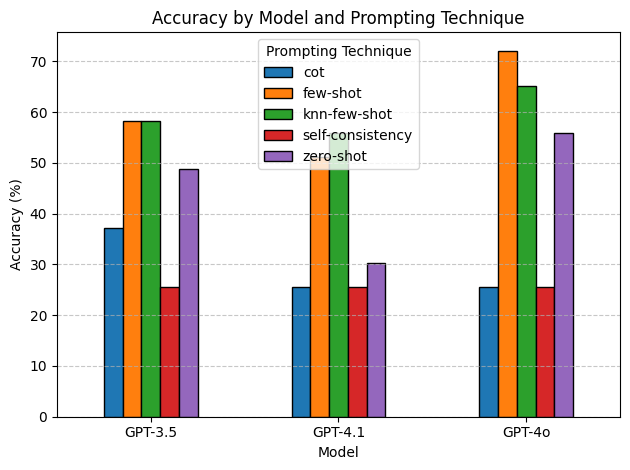

,cot,few-shot,knn-few-shot,self-consistency,zero-shot
GPT-3.5,37.21,58.14,58.14,25.58,48.84
GPT-4.1,25.58,51.16,55.81,25.58,30.23
GPT-4o,25.58,72.09,65.12,25.58,55.81


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Store results in a DataFrame
eval_results = pd.DataFrame({
    "cot": [37.21, 25.58, 25.58],
    "few-shot": [58.14, 51.16, 72.09],
    "knn-few-shot": [58.14, 55.81, 65.12],
    "self-consistency": [25.58, 25.58, 25.58],
    "zero-shot": [48.84, 30.23, 55.81]
}, index=["GPT-3.5", "GPT-4.1", "GPT-4o"])

# Plot
plt.figure(figsize=(12, 6))
eval_results.plot(kind='bar', edgecolor='black')
plt.title("Accuracy by Model and Prompting Technique")
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.legend(title="Prompting Technique")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

eval_results
